In [3]:
# !pip install tensorflow.contrib

In [4]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

#**Read Csv Files**

In [5]:
# Load the CSV file
csv_path_threat = '/kaggle/input/projdatasetv1/Copy of threat_cleaned_audio.csv'
csv_path_non_threat = '/kaggle/input/projdatasetv1/Copy of Non_Threat_Audio.csv'

df_threat = pd.read_csv(csv_path_threat)
df_non_threat = pd.read_csv(csv_path_non_threat)

df_threat['label'] = "Threat"
df_non_threat['label'] = "NonThreat"

df = pd.concat([df_threat, df_non_threat], ignore_index=True)

df.to_csv('/kaggle/working/custome_data.csv', index=False, sep='\t', encoding='utf-8')


# Shuffle the dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


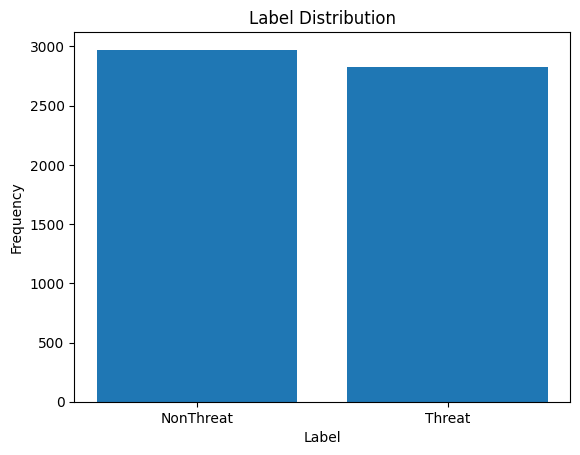

label
NonThreat    2972
Threat       2827
Name: count, dtype: int64


In [6]:
import matplotlib.pyplot as plt

# Assuming df_final contains the shuffled dataframe
label_counts = df['label'].value_counts()

# Plot the distribution of labels
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.show()

print(label_counts)

In [7]:
columns_to_drop = ['filename', 'label']
labels = df.loc[:, 'label']
df_final = df.drop(columns=columns_to_drop)

In [8]:
# Use StandardScaler to perform Z-score normalization
scaler = StandardScaler()
df_normalized_zscore = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns)
df_interpolated = df_normalized_zscore.interpolate()

joblib.dump(scaler, '/kaggle/working/scaler_model.pkl')

['/kaggle/working/scaler_model.pkl']

In [9]:
from keras.regularizers import l2

# Convert labels to numeric values using LabelEncoder
X = df_interpolated.values
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(labels)
y = to_categorical(df['label_encoded'])

# print(X[1300:1323])
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

print(X_train.shape, X_val.shape, X_test.shape)

(4639, 19) (580, 19) (580, 19)


In [10]:
# Reshape the data for CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1)

print(X_train.shape, X_val.shape, X_test.shape)
# Output: (4639, 19, 1, 1) (580, 19, 1, 1) (580, 19, 1, 1)

(4639, 19, 1, 1) (580, 19, 1, 1) (580, 19, 1, 1)


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

class AudioCNN:
    def __init__(self, input_shape):
        self.model = Sequential([
            Input(shape=input_shape),
            Conv2D(32, kernel_size=(2, 1), activation='relu', kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 1)),
            Dropout(0.25),
            
            Conv2D(64, kernel_size=(2, 1), activation='relu', kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 1)),
            Dropout(0.25),
            
            Conv2D(128, kernel_size=(2, 1), activation='relu', kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 1)),
            Dropout(0.25),
            
            Flatten(),
            Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(y.shape[1], activation='softmax')  # For multi-class classification
        ])
        
        self.model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    
    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)
    
    def save_model(self, filename='Hmodel.h5'):  # Change filename extension to .h5
        self.model.save(filename)
        

# Initialize and train the model
input_shape = (X_train.shape[1], 1, 1)
audio_cnn = AudioCNN(input_shape)
audio_cnn.train(X_train, y_train, X_val, y_val, epochs=15, batch_size=32)

# Evaluate the model
loss, accuracy = audio_cnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

audio_cnn.save_model('/kaggle/working/Hmodel.h5')

Epoch 1/15
 57/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7023 - loss: 5.3116

I0000 00:00:1718133375.181738     143 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - accuracy: 0.7762 - loss: 4.9556 - val_accuracy: 0.9517 - val_loss: 3.8243
Epoch 2/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9081 - loss: 3.4999 - val_accuracy: 0.9293 - val_loss: 2.7829
Epoch 3/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9352 - loss: 2.5126 - val_accuracy: 0.9862 - val_loss: 1.9136
Epoch 4/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9500 - loss: 1.8274 - val_accuracy: 0.9862 - val_loss: 1.3647
Epoch 5/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9621 - loss: 1.3007 - val_accuracy: 0.9879 - val_loss: 0.9929
Epoch 6/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9629 - loss: 0.9681 - val_accuracy: 0.9879 - val_loss: 0.7155
Epoch 7/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9665 - loss: 0.7250 - val_accuracy: 0.9931 - val_loss: 0.5411
Epoch 8/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9623 - loss: 0.5720 - val_accuracy: 0.9931 - va

In [12]:
import pickle

# Save the model to a .pkl file
with open('/kaggle/working/cnn_model.pkl', 'wb') as file:
    pickle.dump(audio_cnn, file)

In [ ]:
class LoadModel:
    def load_cnn_model(self, cnn_model_path):
        cnn_model = joblib.load(cnn_model_path)
        return cnn_model
    def load_tfidf_vectorizer(self, tfidf_file_path):
        tfidf_vectorizer = joblib.load(tfidf_file_path)
        return tfidf_vectorizer
    def load_audio_model(self, model_path):
        return joblib.load(model_path)

    def extract_features(self, file_path):
        with open(file_path, "rb") as audio_file:
            audio, sample_rate = librosa.load(audio_file, res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13), axis=1)
        return mfccs

In [ ]:
model_loader = LoadModel()

In [ ]:
cnn_model = model_loader.load_audio_model(model_filename)